# Code Challenge 1 — B10 Reconstruction & Inference Pipeline

This notebook trains a lightweight CNN to reconstruct the missing Sentinel-2 B10 band and then applies a pre-trained EuroSAT classifier to Kaggle tiles after inserting the predicted band.

In [1]:
from pathlib import Path
from datetime import datetime
import os, random, math, re, zipfile, platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import rasterio

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

from transformers import AutoImageProcessor, AutoModelForImageClassification


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() and hasattr(torch, 'mps'):
        torch.mps.manual_seed(seed)  # type: ignore[attr-defined]
    os.environ["PYTHONHASHSEED"] = str(seed)


def resolve_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

DEVICE = resolve_device()
print(f"Using device: {DEVICE}")


/Users/cyrilgabriele/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:
def _env_path(var_name: str, default: Path) -> Path:
    default_path = Path(default)
    value = os.environ.get(var_name)
    return Path(value).expanduser() if value else default_path

REPO_ROOT = Path.cwd()
DATA_BASE = _env_path('EUROSAT_DATA_BASE', Path('/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project'))
DATA_ROOT = _env_path('EUROSAT_DATA_ROOT', DATA_BASE / 'EuroSAT_MS')
DATA_ZIP = _env_path('EUROSAT_DATA_ZIP', DATA_BASE / 'EuroSAT_MS.zip')
MODELS_DIR = _env_path('EUROSAT_MODELS_DIR', REPO_ROOT / 'artifacts' / 'models')
PLOT_DIR = _env_path('EUROSAT_PLOTS_DIR', REPO_ROOT / 'artifacts' / 'plots')
B10_MODEL_DIR = _env_path('EUROSAT_B10_MODEL_DIR', MODELS_DIR / 'cirrus_cnn')
OUTPUT_DIR = _env_path('EUROSAT_OUTPUT_DIR', REPO_ROOT / 'outputs')
KAGGLE_TEST_DIR = _env_path('EUROSAT_KAGGLE_TEST_DIR', DATA_BASE / 'kaggle_data' / 'testset' / 'testset')

for path in (MODELS_DIR, PLOT_DIR, B10_MODEL_DIR, OUTPUT_DIR):
    path.mkdir(parents=True, exist_ok=True)

if not DATA_ROOT.exists():
    if DATA_ZIP.exists():
        print(f"Extracting dataset from {DATA_ZIP} ...")
        with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
            zip_ref.extractall(DATA_ROOT.parent)
    else:
        raise FileNotFoundError(
            f"Dataset directory {DATA_ROOT} not found. Update EUROSAT_DATA_ROOT or place an archive at {DATA_ZIP}."
        )
else:
    print(f"Dataset already available at {DATA_ROOT}")

RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"RUN_TIMESTAMP={RUN_TIMESTAMP}")
print(f"Plots -> {PLOT_DIR}")
print(f"Models -> {MODELS_DIR}")
print(f"Outputs -> {OUTPUT_DIR}")


Dataset already available at /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/EuroSAT_MS
RUN_TIMESTAMP=20251112_114559
Plots -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots
Models -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/models
Outputs -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/outputs


### Cell 3 – Canonical band bookkeeping
The EuroSAT training archive stores all 13 Sentinel-2 bands (`B1`…`B12` plus `B8A`), whereas the Kaggle `.npy` tiles contain only 12 bands and skip `B10`. This cell documents each ordering so we can reason about reshaping tensors: `TRAIN_BAND_ORDER` enumerates the 13-band training layout, `TEST_BAND_ORDER` mirrors the Kaggle layout, and `DROP_BAND_NAME/INDEX` encode the missing band. We precompute `CANONICAL_12_BAND_ORDER` (training order without `B10`) and `TEST_TO_CANONICAL_12`, the index map that reorders a 12-band Kaggle tile into that canonical layout. Those arrays are reused later when we insert a synthetic/predicted `B10` slice and when we fine-tune the classifier, guaranteeing that every dataset obeys the same band semantics despite the test set’s missing channel.


In [3]:
CLASS_NAMES = []
CIRRUS_TILE_PATHS = []

if DATA_ROOT.exists():
    class_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])
    for d in class_dirs:
        label = len(CLASS_NAMES)
        CLASS_NAMES.append(d.name)
        for tif_path in sorted(d.glob('*.tif')):
            CIRRUS_TILE_PATHS.append(tif_path)
else:
    raise FileNotFoundError(f"{DATA_ROOT} not found. Extract the archive first.")

CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

print(f"Detected {len(CLASS_NAMES)} classes")
print(f"Total samples: {len(CIRRUS_TILE_PATHS)}")

TRAIN_BAND_ORDER = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B8A']
TEST_BAND_ORDER = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
DROP_BAND_NAME = 'B10'
DROP_BAND_INDEX = TRAIN_BAND_ORDER.index(DROP_BAND_NAME)
KEEP_IDX_13 = np.array([i for i, band in enumerate(TRAIN_BAND_ORDER) if band != DROP_BAND_NAME])
CANONICAL_12_BAND_ORDER = [band for band in TRAIN_BAND_ORDER if band != DROP_BAND_NAME]
KEEP_IDX_12 = np.arange(len(CANONICAL_12_BAND_ORDER))
TEST_TO_CANONICAL_12 = np.array([CANONICAL_12_BAND_ORDER.index(band) for band in TEST_BAND_ORDER], dtype=np.int64)
CIRRUS_SCALE = 10000.0
CIRRUS_MODEL = None


Detected 10 classes
Total samples: 27000


In [4]:
def reorder_test_to_canonical(arr: np.ndarray) -> np.ndarray:
    """Reorders 12-band Sentinel-2 L2A (test layout) tiles to the canonical training layout without B10."""
    if arr.shape[0] != len(TEST_BAND_ORDER):
        raise ValueError(f"Expected array with {len(TEST_BAND_ORDER)} bands, got {arr.shape[0]}")
    out = np.empty_like(arr)
    for src_idx, dst_idx in enumerate(TEST_TO_CANONICAL_12):
        out[dst_idx] = arr[src_idx]
    return out


In [5]:
class CirrusCNN(nn.Module):
    def __init__(self, in_channels: int = 12, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, 1, kernel_size=1, bias=True)
        )
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
def sample_patches(arr: np.ndarray, num_patches: int, patch_size: int, rng: np.random.Generator):
    c, h, w = arr.shape
    ps = min(patch_size, h, w)
    patches_x = []
    patches_y = []
    for _ in range(num_patches):
        top = int(rng.integers(0, max(1, h - ps + 1)))
        left = int(rng.integers(0, max(1, w - ps + 1)))
        patch = arr[:, top:top + ps, left:left + ps]
        patches_x.append(patch[KEEP_IDX_13])
        patches_y.append(patch[DROP_BAND_INDEX:DROP_BAND_INDEX + 1])
    return patches_x, patches_y


def _iter_patch_batches(tile_paths, patches_per_tile, patch_size, batch_size, rng: np.random.Generator, desc: str | None = None):
    if not tile_paths:
        return

    order = np.arange(len(tile_paths))
    rng.shuffle(order)
    iterator = order
    if desc is not None:
        iterator = tqdm(order, desc=desc, leave=False)
    batch_x, batch_y = [], []
    for idx in iterator:
        path = tile_paths[idx]
        with rasterio.open(path) as src:
            arr = src.read().astype(np.float32)
        if arr.shape[0] != 13:
            continue
        arr = np.clip(arr, 0.0, CIRRUS_SCALE) / CIRRUS_SCALE
        px, py = sample_patches(arr, patches_per_tile, patch_size, rng)
        for x_patch, y_patch in zip(px, py):
            batch_x.append(x_patch)
            batch_y.append(y_patch)
            if len(batch_x) == batch_size:
                yield torch.from_numpy(np.stack(batch_x)).float(), torch.from_numpy(np.stack(batch_y)).float()
                batch_x, batch_y = [], []
    if batch_x:
        yield torch.from_numpy(np.stack(batch_x)).float(), torch.from_numpy(np.stack(batch_y)).float()


def fit_cirrus_cnn(sample_paths,
                    patches_per_tile: int = 64,
                    patch_size: int = 64,
                    epochs: int = 5,
                    batch_size: int = 128,
                    lr: float = 5e-4,
                    val_fraction: float = 0.1,
                    max_tiles: int | None = None,
                    early_stopping_patience: int = 3) -> dict:
    if not sample_paths:
        raise ValueError("No samples provided for cirrus CNN fitting")

    base_rng = np.random.default_rng(RANDOM_SEED)
    paths = list(sample_paths)
    if max_tiles is not None and len(paths) > max_tiles:
        idx = base_rng.choice(len(paths), size=max_tiles, replace=False)
        paths = [paths[i] for i in idx]
    base_rng.shuffle(paths)

    val_count = max(1, int(len(paths) * val_fraction))
    val_paths = paths[:val_count]
    train_paths = paths[val_count:]
    if not train_paths:
        raise ValueError("Not enough tiles for training after validation split")

    print(f"[CirrusCNN] Training on {len(train_paths)} tiles (+{len(val_paths)} val) with {patches_per_tile} patches per tile per epoch.")

    model = CirrusCNN().to(DEVICE)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_state = None
    best_val = float('inf')
    best_epoch = 0

    history = []

    patience = max(1, early_stopping_patience)
    no_improve_epochs = 0
    for epoch in range(1, epochs + 1):
        epoch_rng = np.random.default_rng(base_rng.integers(0, 1 << 32))
        model.train()
        train_loss = 0.0
        train_samples = 0
        for xb, yb in _iter_patch_batches(train_paths, patches_per_tile, patch_size, batch_size, epoch_rng, desc=f'Train patches (epoch {epoch})'):
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_samples += xb.size(0)
        train_loss = train_loss / max(1, train_samples)

        val_rng = np.random.default_rng(epoch_rng.integers(0, 1 << 32))
        model.eval()
        val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for xb, yb in _iter_patch_batches(val_paths, patches_per_tile, patch_size, batch_size, val_rng, desc=f'Val patches (epoch {epoch})'):
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * xb.size(0)
                val_samples += xb.size(0)
        val_loss = val_loss / max(1, val_samples)
        print(f"[CirrusCNN] epoch {epoch}/{epochs} train={train_loss:.6f} val={val_loss:.6f}")

        history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'train_samples': train_samples, 'val_samples': val_samples})

        if val_loss < best_val and val_samples > 0:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}; best val {best_val:.6f} at epoch {best_epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    eval_rng = np.random.default_rng(RANDOM_SEED + 1234)
    mae_sum = 0.0
    mse_sum = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for xb, yb in _iter_patch_batches(paths, patches_per_tile, patch_size, 256, eval_rng, desc='Evaluating cirrus CNN'):
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds = model(xb)
            mae_sum += torch.nn.functional.l1_loss(preds, yb, reduction='sum').item()
            mse_sum += torch.nn.functional.mse_loss(preds, yb, reduction='sum').item()
            count += xb.size(0)
    mae = mae_sum / max(1, count)
    rmse = math.sqrt(mse_sum / max(1, count))

    print(f"[CirrusCNN] Aggregated over ~{count} patches | MAE={mae:.6f} | RMSE={rmse:.6f}")

    if history:
        hist_df = pd.DataFrame(history)
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(hist_df['epoch'], hist_df['train_loss'], label='Train')
        ax.plot(hist_df['epoch'], hist_df['val_loss'], label='Val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('SmoothL1 Loss')
        ax.set_title('CirrusCNN Training History')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)
        fig.tight_layout()
        plot_path = PLOT_DIR / f'cirrus_cnn_history_{RUN_TIMESTAMP}.png'
        fig.savefig(plot_path, dpi=180, bbox_inches='tight')
        plt.show()
        plt.close(fig)
        print(f"Saved CirrusCNN training plot to {plot_path}")

    return {
        'module': model,
        'mae': mae,
        'rmse': rmse,
        'scale': CIRRUS_SCALE,
    }


def synthesize_cirrus(arr: np.ndarray, band_order: str | None = None) -> np.ndarray:
    arr = np.asarray(arr, dtype=np.float32)
    if CIRRUS_MODEL is None:
        raise RuntimeError('CIRRUS_MODEL is None. Train or load the B10 reconstruction model before calling synthesize_cirrus.')

    if band_order is None:
        if arr.shape[0] == len(TRAIN_BAND_ORDER):
            band_order = 'train'
        elif arr.shape[0] == len(TEST_BAND_ORDER):
            band_order = 'test'
        elif arr.shape[0] == len(CANONICAL_12_BAND_ORDER):
            band_order = 'canonical_12'
        else:
            raise ValueError(f"Expected 12 or 13 bands, got {arr.shape}")

    scale = CIRRUS_MODEL['scale']
    if band_order == 'train':
        arr_scaled = np.clip(arr, 0.0, scale) / scale
        feats = arr_scaled[KEEP_IDX_13]
    elif band_order == 'test':
        reordered = reorder_test_to_canonical(arr)
        arr_scaled = np.clip(reordered, 0.0, scale) / scale
        feats = arr_scaled
    elif band_order == 'canonical_12':
        if arr.shape[0] != len(CANONICAL_12_BAND_ORDER):
            raise ValueError(f"Expected canonical 12-band array with shape (12, H, W), got {arr.shape}")
        arr_scaled = np.clip(arr, 0.0, scale) / scale
        feats = arr_scaled
    else:
        raise ValueError(f"Unsupported band_order: {band_order}")

    tensor = torch.from_numpy(feats).unsqueeze(0).to(DEVICE)
    module = CIRRUS_MODEL['module'].to(DEVICE)
    CIRRUS_MODEL['module'] = module
    module.eval()
    with torch.no_grad():
        pred = module(tensor).squeeze(0).squeeze(0).detach().cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0) * scale
    return pred.astype(np.float32)


def pad_to_13_bands(arr: np.ndarray, band_order: str | None = None) -> np.ndarray:
    arr = np.asarray(arr, dtype=np.float32)
    if band_order is None:
        if arr.shape[0] == len(TRAIN_BAND_ORDER):
            band_order = 'train'
        elif arr.shape[0] == len(TEST_BAND_ORDER):
            band_order = 'test'
        elif arr.shape[0] == len(CANONICAL_12_BAND_ORDER):
            band_order = 'canonical_12'
        else:
            raise ValueError(f"Expected 12 or 13 bands, got {arr.shape}")

    if band_order == 'train':
        out = arr.copy()
        out[DROP_BAND_INDEX] = synthesize_cirrus(arr, band_order='train')
        return out

    if band_order == 'test':
        canonical = reorder_test_to_canonical(arr)
    elif band_order == 'canonical_12':
        if arr.shape[0] != len(CANONICAL_12_BAND_ORDER):
            raise ValueError(f"Expected canonical 12-band array with shape (12, H, W), got {arr.shape}")
        canonical = arr
    else:
        raise ValueError(f"Unsupported band_order: {band_order}")

    cirrus = synthesize_cirrus(canonical, band_order='canonical_12')
    return np.concatenate(
        [canonical[:DROP_BAND_INDEX], cirrus[np.newaxis, ...], canonical[DROP_BAND_INDEX:]],
        axis=0
    )


def robust_normalize(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    out = np.empty_like(arr)
    for i in range(arr.shape[0]):
        band = arr[i]
        lo, hi = np.percentile(band, [2, 98])
        if hi > lo:
            band = (band - lo) / (hi - lo)
        else:
            min_v, max_v = band.min(), band.max()
            if max_v > min_v:
                band = (band - min_v) / (max_v - min_v)
            else:
                band = np.zeros_like(band)
        out[i] = np.clip(band, 0.0, 1.0)
    return out




[CirrusCNN] Training on 24300 tiles (+2700 val) with 64 patches per tile per epoch.


[CirrusCNN] epoch 1/3 train=0.000277 val=0.000001


[CirrusCNN] epoch 2/3 train=0.000000 val=0.000000


[CirrusCNN] epoch 3/3 train=0.000000 val=0.000000


[CirrusCNN] Aggregated over ~1728000 patches | MAE=1.292108 | RMSE=0.030317


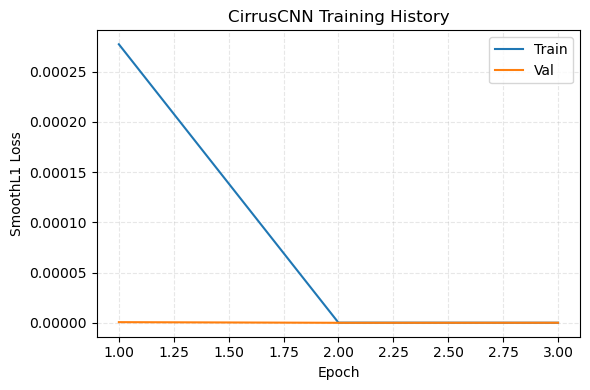

Saved CirrusCNN training plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/cirrus_cnn_history_20251112_114559.png
Saved B10 reconstruction weights to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/models/cirrus_cnn/cirrus_cnn_20251112_114559.pt


In [6]:
cirrus_paths = CIRRUS_TILE_PATHS
CIRRUS_MODEL = fit_cirrus_cnn(cirrus_paths, epochs=3, patches_per_tile=64, patch_size=64)
CIRRUS_MODEL['module'] = CIRRUS_MODEL['module'].to(DEVICE)
CIRRUS_MODEL['module'].eval()

cirrus_state_dict = {k: v.detach().cpu() for k, v in CIRRUS_MODEL['module'].state_dict().items()}

b10_bundle = {
    'state_dict': cirrus_state_dict,
    'mae': CIRRUS_MODEL['mae'],
    'rmse': CIRRUS_MODEL['rmse'],
    'scale': CIRRUS_MODEL['scale'],
    'drop_band_index': DROP_BAND_INDEX,
    'keep_idx_12': KEEP_IDX_12,
    'keep_idx_13': KEEP_IDX_13,
    'train_band_order': TRAIN_BAND_ORDER,
    'test_band_order': TEST_BAND_ORDER,
    'canonical_12_band_order': CANONICAL_12_BAND_ORDER,
}

b10_model_path = B10_MODEL_DIR / f'cirrus_cnn_{RUN_TIMESTAMP}.pt'
torch.save(b10_bundle, b10_model_path)
print(f"Saved B10 reconstruction weights to {b10_model_path}")

In [7]:
MODEL_ID = 'Rhodham96/EuroSatCNN'
MODEL_SOURCE = 'auto'  # auto -> local first, fallback to HF
LOCAL_MODEL_DIR_CANDIDATES = [
    Path('/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/Rhodham96-EuroSatCNN'),
    MODELS_DIR / 'Rhodham96-EuroSatCNN',
    Path('./local_models/Rhodham96-EuroSatCNN'),
    Path('./models/Rhodham96-EuroSatCNN'),
    Path.home() / 'models' / 'Rhodham96-EuroSatCNN',
]

LOCAL_MODEL_DIR = next((p for p in LOCAL_MODEL_DIR_CANDIDATES if p.exists()), LOCAL_MODEL_DIR_CANDIDATES[0])
LOCAL_MODEL_DEF = LOCAL_MODEL_DIR / 'model_def.py'
LOCAL_MODEL_WEIGHTS = LOCAL_MODEL_DIR / 'pytorch_model.bin'

print(f"Loading classifier {MODEL_ID} (source={MODEL_SOURCE})")
print(f"Resolved local directory: {LOCAL_MODEL_DIR}")
model = None
processor = None
image_size = 224

local_available = LOCAL_MODEL_DEF.exists() and LOCAL_MODEL_WEIGHTS.exists()

if MODEL_SOURCE in ('auto', 'local') and local_available:
    import importlib.util
    spec = importlib.util.spec_from_file_location('eurosat_local_model', LOCAL_MODEL_DEF)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    if not hasattr(module, 'EuroSATCNN'):
        raise AttributeError(f"EuroSATCNN class not found in {LOCAL_MODEL_DEF}")
    EuroSATCNN = module.EuroSATCNN
    model = EuroSATCNN(num_classes=len(CLASS_NAMES))
    state_dict = torch.load(LOCAL_MODEL_WEIGHTS, map_location='cpu')
    if isinstance(state_dict, dict) and 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    model.load_state_dict(state_dict)
    image_size = getattr(model, 'image_size', getattr(model, 'input_resolution', 64))
    if not hasattr(model, 'image_size'):
        model.image_size = image_size
    print(f"Loaded local weights from {LOCAL_MODEL_WEIGHTS}")

if model is None and MODEL_SOURCE in ('auto', 'hf'):
    print(f"Falling back to Hugging Face hub for {MODEL_ID}")
    model = AutoModelForImageClassification.from_pretrained(MODEL_ID)
    image_size = getattr(model.config, 'image_size', image_size)
    try:
        processor = AutoImageProcessor.from_pretrained(MODEL_ID)
    except (OSError, IndexError) as hf_proc_err:
        print(f"Processor load failed: {hf_proc_err}")
        processor = None

if processor is None:
    print('Using fallback processor.')

    class EuroSatFallbackImageProcessor:
        def __init__(self, image_size: int = 224):
            self.image_size = image_size

        def _prep_single(self, image):
            if isinstance(image, np.ndarray):
                tensor = torch.from_numpy(image)
                if tensor.dtype != torch.float32:
                    tensor = tensor.float()
            elif torch.is_tensor(image):
                tensor = image.float()
            else:
                tensor = torch.from_numpy(np.asarray(image, dtype=np.float32))

            if tensor.ndim != 3:
                raise ValueError(f"Expected image with 3 dims, got {tuple(tensor.shape)}")

            if tensor.shape[0] not in (3, 13):
                tensor = tensor.permute(2, 0, 1)

            tensor = tensor.clamp(0.0, 1.0)

            if tensor.shape[1:] != (self.image_size, self.image_size):
                tensor = torch.nn.functional.interpolate(
                    tensor.unsqueeze(0),
                    size=(self.image_size, self.image_size),
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0)

            return tensor

        def __call__(self, images, return_tensors=None):
            if isinstance(images, (list, tuple)):
                batch = torch.stack([self._prep_single(img) for img in images])
            else:
                batch = self._prep_single(images).unsqueeze(0)

            if return_tensors in (None, 'pt'):
                return {'pixel_values': batch}

            raise ValueError(f"Unsupported return_tensors value: {return_tensors!r}")

    processor = EuroSatFallbackImageProcessor(image_size=image_size)

if not hasattr(model, 'config'):
    from types import SimpleNamespace
    model.config = SimpleNamespace()

model.config.label2id = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
model.config.id2label = {idx: cls for cls, idx in model.config.label2id.items()}
model.config.num_labels = len(CLASS_NAMES)
model.config.image_size = image_size

model.to(DEVICE)
model.eval()
print('Classifier ready for inference.')

def get_model_logits(model, pixel_values):
    try:
        outputs = model(pixel_values=pixel_values)
    except TypeError:
        outputs = model(pixel_values)
    if isinstance(outputs, torch.Tensor):
        return outputs
    if isinstance(outputs, dict):
        if 'logits' in outputs:
            return outputs['logits']
        raise KeyError("Model output dict missing 'logits'")
    if hasattr(outputs, 'logits'):
        return outputs.logits
    raise RuntimeError('Model output does not contain logits')


Loading classifier Rhodham96/EuroSatCNN (source=auto)
Resolved local directory: /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/Rhodham96-EuroSatCNN
Loaded local weights from /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/Rhodham96-EuroSatCNN/pytorch_model.bin
Using fallback processor.
Classifier ready for inference.


In [8]:
# Fine-tune the classifier using CirrusCNN-synthesized B10 inputs so it sees the same distribution as at inference time


def _build_finetune_records(val_fraction: float = 0.1, test_fraction: float = 0.0, limit_per_class: int | None = None, seed: int = RANDOM_SEED):
    if not (0.0 < val_fraction < 1.0):
        raise ValueError('val_fraction must be between 0 and 1 for fine-tuning splits')
    if not (0.0 <= test_fraction < 1.0):
        raise ValueError('test_fraction must be between 0 and 1 for fine-tuning splits')
    if val_fraction + test_fraction >= 1.0:
        raise ValueError('val_fraction + test_fraction must sum to less than 1.0 for fine-tuning splits')
    rng = np.random.default_rng(seed)
    train_records: list[tuple[Path, int]] = []
    val_records: list[tuple[Path, int]] = []
    test_records: list[tuple[Path, int]] = []
    for class_name in CLASS_NAMES:
        class_idx = CLASS_TO_IDX[class_name]
        class_dir = DATA_ROOT / class_name
        tif_paths = sorted(class_dir.glob('*.tif'))
        if not tif_paths:
            continue
        if limit_per_class is not None and len(tif_paths) > limit_per_class:
            selection = rng.choice(len(tif_paths), size=limit_per_class, replace=False)
            tif_paths = [tif_paths[i] for i in selection]
        order = rng.permutation(len(tif_paths))
        tif_paths = [tif_paths[i] for i in order]
        if len(tif_paths) < 2:
            train_records.extend((path, class_idx) for path in tif_paths)
            continue
        total = len(tif_paths)
        val_count = 0
        test_count = 0
        if val_fraction > 0.0:
            val_count = max(1, int(total * val_fraction))
            val_count = min(total - 1, val_count)
        remaining = total - val_count
        if test_fraction > 0.0 and remaining > 1:
            test_count = max(1, int(total * test_fraction))
            test_count = min(test_count, remaining - 1)
        val_slice = tif_paths[:val_count]
        test_slice = tif_paths[val_count:val_count + test_count]
        train_slice = tif_paths[val_count + test_count:]
        if not train_slice:
            raise RuntimeError('Unable to keep at least one training tile per class; adjust val/test fractions or increase data availability.')
        val_records.extend((path, class_idx) for path in val_slice)
        test_records.extend((path, class_idx) for path in test_slice)
        train_records.extend((path, class_idx) for path in train_slice)
    if not train_records or not val_records:
        raise RuntimeError('Unable to build stratified fine-tuning splits; consider lowering val_fraction or increasing data availability.')
    if test_fraction > 0.0 and not test_records:
        raise RuntimeError('Unable to build stratified fine-tuning test split; consider lowering test_fraction or increasing data availability.')
    return train_records, val_records, test_records


class EuroSATCirrusFinetuneDataset(Dataset):
    def __init__(self, records, processor, inject_cirrus_b10: bool = True):
        if processor is None:
            raise RuntimeError('processor must be initialized before building the fine-tuning dataset')
        if inject_cirrus_b10 and CIRRUS_MODEL is None:
            raise RuntimeError('CIRRUS_MODEL is None; train or load the B10 reconstruction model before fine-tuning the classifier')
        self.records = records
        self.processor = processor
        self.inject_cirrus_b10 = inject_cirrus_b10

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, idx: int):
        path, label = self.records[idx]
        with rasterio.open(path) as src:
            arr = src.read().astype(np.float32)
        if self.inject_cirrus_b10:
            arr = pad_to_13_bands(arr, band_order='train')
        arr = robust_normalize(arr)
        arr = np.moveaxis(arr, 0, -1)
        inputs = self.processor(images=arr, return_tensors='pt')
        pixel_values = inputs['pixel_values'].squeeze(0)
        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(label, dtype=torch.long),
            'path': str(path),
        }


def _save_plot(fig, filename: str):
    path = PLOT_DIR / filename
    fig.savefig(path, dpi=180, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved plot to {path}")


def _plot_training_curves(history: list[dict], tag: str):
    if not history:
        return
    epochs = [entry['epoch'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]
    train_acc = [entry['train_acc'] for entry in history]
    val_acc = [entry['val_acc'] for entry in history]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs, train_acc, label='Train')
    axes[0].plot(epochs, val_acc, label='Val')
    axes[0].set_title('Accuracy over epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True, linestyle='--', alpha=0.3)
    axes[0].legend()

    axes[1].plot(epochs, train_loss, label='Train')
    axes[1].plot(epochs, val_loss, label='Val')
    axes[1].set_title('Loss over epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, linestyle='--', alpha=0.3)
    axes[1].legend()

    fig.tight_layout()
    _save_plot(fig, f'{tag}_accuracy_loss.png')


def _plot_confusion_matrix(cm: np.ndarray, tag: str):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(CLASS_NAMES)),
           yticks=np.arange(len(CLASS_NAMES)),
           xticklabels=CLASS_NAMES,
           yticklabels=CLASS_NAMES,
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion matrix (test set)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    fig.tight_layout()
    _save_plot(fig, f'{tag}_confusion_matrix.png')


def _plot_per_class_metrics(precision: np.ndarray, recall: np.ndarray, f1: np.ndarray, tag: str):
    indices = np.arange(len(CLASS_NAMES))
    width = 0.25
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(indices - width, precision, width, label='Precision')
    ax.bar(indices, recall, width, label='Recall')
    ax.bar(indices + width, f1, width, label='F1')
    ax.set_xticks(indices)
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.set_title('Per-class metrics (test set)')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.legend()
    fig.tight_layout()
    _save_plot(fig, f'{tag}_per_class_metrics.png')


def _plot_roc_curves(y_true: np.ndarray, probs: np.ndarray, tag: str):
    classes = np.arange(len(CLASS_NAMES))
    y_bin = label_binarize(y_true, classes=classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    auc_scores: dict[str, float] = {}
    for idx, class_name in enumerate(CLASS_NAMES):
        fpr, tpr, _ = roc_curve(y_bin[:, idx], probs[:, idx])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_name] = roc_auc
        ax.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.3f})')
    micro_fpr, micro_tpr, _ = roc_curve(y_bin.ravel(), probs.ravel())
    micro_auc = auc(micro_fpr, micro_tpr)
    auc_scores['micro'] = micro_auc
    ax.plot(micro_fpr, micro_tpr, color='black', linewidth=2, label=f'Micro (AUC={micro_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curves (one-vs-rest)')
    ax.legend(fontsize='small', ncol=2)
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.tight_layout()
    _save_plot(fig, f'{tag}_roc_curves.png')
    return auc_scores


def _plot_roc_auc_bars(auc_scores: dict[str, float], tag: str):
    labels = list(auc_scores.keys())
    scores = [auc_scores[label] for label in labels]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(labels, scores, color='teal')
    ax.set_ylim(0, 1)
    ax.set_ylabel('AUC')
    ax.set_title('ROC-AUC by class')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    fig.tight_layout()
    _save_plot(fig, f'{tag}_roc_auc_bars.png')


def _plot_precision_recall_curves(y_true: np.ndarray, probs: np.ndarray, tag: str):
    classes = np.arange(len(CLASS_NAMES))
    y_bin = label_binarize(y_true, classes=classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    for idx, class_name in enumerate(CLASS_NAMES):
        precision, recall, _ = precision_recall_curve(y_bin[:, idx], probs[:, idx])
        pr_auc = auc(recall, precision)
        ax.plot(recall, precision, label=f'{class_name} (AUC={pr_auc:.3f})')
    precision_micro, recall_micro, _ = precision_recall_curve(y_bin.ravel(), probs.ravel())
    pr_auc_micro = auc(recall_micro, precision_micro)
    ax.plot(recall_micro, precision_micro, color='black', linewidth=2, label=f'Micro (AUC={pr_auc_micro:.3f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall curves (one-vs-rest)')
    ax.legend(fontsize='small', ncol=2)
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.tight_layout()
    _save_plot(fig, f'{tag}_precision_recall_curves.png')


def _plot_score_distribution(y_true: np.ndarray, y_pred: np.ndarray, probs: np.ndarray, tag: str):
    max_probs = probs.max(axis=1)
    correct = y_pred == y_true
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(max_probs[correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
    ax.hist(max_probs[~correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
    ax.set_xlabel('Predicted probability (max class)')
    ax.set_ylabel('Density')
    ax.set_title('Prediction confidence distribution')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.tight_layout()
    _save_plot(fig, f'{tag}_score_distribution.png')


def finetune_classifier_with_cirrus(model, processor, cfg: dict):
    train_records, val_records, test_records = _build_finetune_records(
        val_fraction=cfg.get('val_fraction', 0.1),
        test_fraction=cfg.get('test_fraction', 0.0),
        limit_per_class=cfg.get('limit_per_class'),
        seed=cfg.get('seed', RANDOM_SEED),
    )
    train_dataset = EuroSATCirrusFinetuneDataset(train_records, processor, inject_cirrus_b10=True)
    val_dataset = EuroSATCirrusFinetuneDataset(val_records, processor, inject_cirrus_b10=True)
    test_dataset = EuroSATCirrusFinetuneDataset(test_records, processor, inject_cirrus_b10=True) if test_records else None

    num_workers = cfg.get('num_workers')
    if num_workers is None:
        num_workers = 0 if platform.system() == 'Darwin' else 4
    pin_memory = DEVICE.type == 'cuda'

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.get('train_batch_size', 32),
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.get('val_batch_size', 64),
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    test_loader = None
    if test_dataset is not None:
        test_loader = DataLoader(
            test_dataset,
            batch_size=cfg.get('test_batch_size', cfg.get('val_batch_size', 64)),
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )

    print(f"[FineTune] Split sizes -> train: {len(train_records)} | val: {len(val_records)} | test: {len(test_records)}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.get('lr', 5e-5),
        weight_decay=cfg.get('weight_decay', 1e-2),
    )
    max_grad_norm = cfg.get('max_grad_norm', 1.0)
    epochs = cfg.get('epochs', 3)
    transfer_non_blocking = DEVICE.type == 'cuda'

    best_state = None
    best_val_acc = 0.0
    best_epoch = 0
    history = []

    patience = max(1, cfg.get('early_stopping_patience', 3))
    no_improve_epochs = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_samples = 0
        for batch in tqdm(train_loader, desc=f'Fine-tune train {epoch}/{epochs}', leave=False):
            pixel_values = batch['pixel_values'].to(DEVICE, non_blocking=transfer_non_blocking)
            labels = batch['labels'].to(DEVICE, non_blocking=transfer_non_blocking)
            optimizer.zero_grad(set_to_none=True)
            logits = get_model_logits(model, pixel_values)
            loss = criterion(logits, labels)
            loss.backward()
            if max_grad_norm is not None and max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            train_correct += (logits.argmax(dim=1) == labels).sum().item()
            train_samples += labels.size(0)
        train_loss = train_loss / max(1, train_samples)
        train_acc = train_correct / max(1, train_samples)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_samples = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Fine-tune val {epoch}/{epochs}', leave=False):
                pixel_values = batch['pixel_values'].to(DEVICE, non_blocking=transfer_non_blocking)
                labels = batch['labels'].to(DEVICE, non_blocking=transfer_non_blocking)
                logits = get_model_logits(model, pixel_values)
                loss = criterion(logits, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (logits.argmax(dim=1) == labels).sum().item()
                val_samples += labels.size(0)
        val_loss = val_loss / max(1, val_samples)
        val_acc = val_correct / max(1, val_samples)

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'train_samples': train_samples,
            'val_samples': val_samples,
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"[FineTune] Early stopping triggered at epoch {epoch} (patience={patience}).")
                break

        print(f"[FineTune] epoch {epoch}/{epochs} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"Loaded best fine-tuned weights from epoch {best_epoch} (val_acc={best_val_acc:.4f})")

    test_results = None
    test_plot_payload = None
    if test_loader is not None:
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_samples = 0
        collected_probs = []
        collected_labels = []
        collected_preds = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc='Fine-tune test', leave=False):
                pixel_values = batch['pixel_values'].to(DEVICE, non_blocking=transfer_non_blocking)
                labels = batch['labels'].to(DEVICE, non_blocking=transfer_non_blocking)
                logits = get_model_logits(model, pixel_values)
                probs = torch.softmax(logits, dim=1)
                loss = criterion(logits, labels)
                test_loss += loss.item() * labels.size(0)
                predictions = probs.argmax(dim=1)
                test_correct += (predictions == labels).sum().item()
                test_samples += labels.size(0)
                collected_probs.append(probs.detach().cpu())
                collected_labels.append(labels.detach().cpu())
                collected_preds.append(predictions.detach().cpu())
        test_loss = test_loss / max(1, test_samples)
        test_acc = test_correct / max(1, test_samples)
        if collected_probs:
            probs_np = torch.cat(collected_probs).numpy()
            labels_np = torch.cat(collected_labels).numpy()
            preds_np = torch.cat(collected_preds).numpy()
            test_plot_payload = {
                'labels': labels_np,
                'preds': preds_np,
                'probs': probs_np,
            }
        test_results = {
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_samples': test_samples,
        }
        print(f"[FineTune/Test] loss={test_loss:.4f} acc={test_acc:.4f} | samples={test_samples}")

    plot_tag = f'finetune_{RUN_TIMESTAMP}'
    _plot_training_curves(history, plot_tag)
    if test_plot_payload is not None:
        labels = test_plot_payload['labels']
        preds = test_plot_payload['preds']
        probs = test_plot_payload['probs']
        cm = confusion_matrix(labels, preds, labels=list(range(len(CLASS_NAMES))))
        _plot_confusion_matrix(cm, plot_tag)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels,
            preds,
            labels=list(range(len(CLASS_NAMES))),
            zero_division=0,
        )
        _plot_per_class_metrics(precision, recall, f1, plot_tag)
        auc_scores = _plot_roc_curves(labels, probs, plot_tag)
        _plot_roc_auc_bars(auc_scores, plot_tag)
        _plot_precision_recall_curves(labels, probs, plot_tag)
        _plot_score_distribution(labels, preds, probs, plot_tag)

    model.eval()
    if cfg.get('save_weights', True):
        tag = MODEL_ID.replace('/', '_') if MODEL_ID else 'eurosat_classifier'
        save_path = MODELS_DIR / f'{tag}_cirrus_finetuned_{RUN_TIMESTAMP}.pt'
        torch.save({
            'state_dict': model.state_dict(),
            'config': getattr(model, 'config', None),
            'history': history,
            'class_names': CLASS_NAMES,
            'test_results': test_results,
        }, save_path)
        print(f"Saved fine-tuned classifier weights to {save_path}")

    return history, test_results


FINETUNE_CFG = {
    'val_fraction': 0.15,
    'test_fraction': 0.15,
    'limit_per_class': None,
    'epochs': 20,
    'early_stopping_patience': 3,
    'train_batch_size': 32,
    'val_batch_size': 64,
    'test_batch_size': 64,
    'lr': 5e-5,
    'weight_decay': 1e-2,
    'max_grad_norm': 1.0,
    'num_workers': None,
    'save_weights': True,
    'seed': RANDOM_SEED,
}
RUN_CLASSIFIER_FINE_TUNE = True

finetune_history = None
finetune_test_results = None
if RUN_CLASSIFIER_FINE_TUNE:
    finetune_history, finetune_test_results = finetune_classifier_with_cirrus(model, processor, FINETUNE_CFG)
else:
    print('Skipping classifier fine-tuning. Set RUN_CLASSIFIER_FINE_TUNE = True to enable it.')




[FineTune] Split sizes -> train: 18900 | val: 4050 | test: 4050


[FineTune] epoch 1/20 | train_loss=2.0665 train_acc=0.4220 | val_loss=1.3684 val_acc=0.5427


[FineTune] epoch 2/20 | train_loss=1.1567 train_acc=0.6116 | val_loss=1.0284 val_acc=0.6637


[FineTune] epoch 3/20 | train_loss=0.9174 train_acc=0.6913 | val_loss=0.8664 val_acc=0.7042


[FineTune] epoch 4/20 | train_loss=0.7878 train_acc=0.7370 | val_loss=0.7549 val_acc=0.7531


[FineTune] epoch 5/20 | train_loss=0.6981 train_acc=0.7683 | val_loss=0.6820 val_acc=0.7716


[FineTune] epoch 6/20 | train_loss=0.6375 train_acc=0.7867 | val_loss=0.6339 val_acc=0.7864


[FineTune] epoch 7/20 | train_loss=0.5912 train_acc=0.8003 | val_loss=0.6284 val_acc=0.7911


[FineTune] epoch 8/20 | train_loss=0.5539 train_acc=0.8093 | val_loss=0.5656 val_acc=0.8099


[FineTune] epoch 9/20 | train_loss=0.5237 train_acc=0.8214 | val_loss=0.5368 val_acc=0.8212


[FineTune] epoch 10/20 | train_loss=0.4991 train_acc=0.8279 | val_loss=0.5220 val_acc=0.8289


[FineTune] epoch 11/20 | train_loss=0.4760 train_acc=0.8349 | val_loss=0.4947 val_acc=0.8370


[FineTune] epoch 12/20 | train_loss=0.4571 train_acc=0.8429 | val_loss=0.5005 val_acc=0.8400


[FineTune] epoch 13/20 | train_loss=0.4402 train_acc=0.8498 | val_loss=0.4787 val_acc=0.8435


[FineTune] epoch 14/20 | train_loss=0.4229 train_acc=0.8562 | val_loss=0.4958 val_acc=0.8425


[FineTune] epoch 15/20 | train_loss=0.4113 train_acc=0.8584 | val_loss=0.4675 val_acc=0.8499


[FineTune] epoch 16/20 | train_loss=0.3961 train_acc=0.8649 | val_loss=0.4490 val_acc=0.8511


[FineTune] epoch 17/20 | train_loss=0.3826 train_acc=0.8679 | val_loss=0.4211 val_acc=0.8674


[FineTune] epoch 18/20 | train_loss=0.3714 train_acc=0.8722 | val_loss=0.4084 val_acc=0.8681


[FineTune] epoch 19/20 | train_loss=0.3616 train_acc=0.8762 | val_loss=0.3943 val_acc=0.8751


[FineTune] epoch 20/20 | train_loss=0.3487 train_acc=0.8781 | val_loss=0.3903 val_acc=0.8758
Loaded best fine-tuned weights from epoch 20 (val_acc=0.8758)


[FineTune/Test] loss=0.4012 acc=0.8647 | samples=4050
Saved plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/finetune_20251112_114559_accuracy_loss.png
Saved plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/finetune_20251112_114559_confusion_matrix.png
Saved plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/finetune_20251112_114559_per_class_metrics.png
Saved plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/finetune_20251112_114559_roc_curves.png
Saved plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/finetune_20251112_114559_roc_auc_bars.png
Saved plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/finetune_20251112_114559_precision_recall_curves.png
Sav

In [9]:
class EuroSATNPYDataset(Dataset):
    def __init__(self, paths, processor):
        self.paths = paths
        self.processor = processor

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        arr = np.load(path, allow_pickle=False)
        if arr.ndim == 3 and arr.shape[0] not in (12, 13) and arr.shape[-1] in (12, 13):
            arr = np.moveaxis(arr, -1, 0)
        arr = pad_to_13_bands(arr, band_order='test')
        arr = robust_normalize(arr)
        arr = np.moveaxis(arr, 0, -1)
        inputs = self.processor(images=arr, return_tensors='pt')
        pixel_values = inputs['pixel_values'].squeeze(0)
        sample_id = self._extract_id(path.stem)
        return {'pixel_values': pixel_values, 'id': sample_id}

    @staticmethod
    def _extract_id(stem: str) -> int:
        match = re.search(r'(\d+)$', stem)
        if match:
            return int(match.group(1))
        digits = ''.join(ch for ch in stem if ch.isdigit())
        return int(digits) if digits else -1


In [10]:
TEST_ROOT = KAGGLE_TEST_DIR
if not TEST_ROOT.exists():
    raise FileNotFoundError(f"Expected test directory at {TEST_ROOT}")

npy_paths = sorted(TEST_ROOT.glob('*.npy'))
if not npy_paths:
    npy_paths = sorted(TEST_ROOT.glob('**/*.npy'))

if len(npy_paths) == 0:
    raise FileNotFoundError('No .npy files found in Kaggle test directory')

print(f"Found {len(npy_paths)} inference tiles")

BATCH_SIZE = 32
NUM_WORKERS = 0 if platform.system() == 'Darwin' else 2
PIN_MEMORY = DEVICE.type == 'cuda'

kaggle_dataset = EuroSATNPYDataset(npy_paths, processor)
kaggle_loader = DataLoader(
    kaggle_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

model.eval()
pred_ids = []
pred_indices = []
transfer_non_blocking = DEVICE.type == 'cuda'

with torch.no_grad():
    for batch in tqdm(kaggle_loader, desc='Kaggle inference'):
        pixel_values = batch['pixel_values'].to(DEVICE, non_blocking=transfer_non_blocking)
        logits = get_model_logits(model, pixel_values)
        preds = logits.argmax(dim=1).cpu().tolist()
        pred_indices.extend(preds)
        if isinstance(batch['id'], torch.Tensor):
            pred_ids.extend(batch['id'].cpu().tolist())
        else:
            pred_ids.extend(batch['id'])

pred_labels = [IDX_TO_CLASS[idx] for idx in pred_indices]
submission = pd.DataFrame({'test_id': pred_ids, 'label': pred_labels})
submission = submission.sort_values('test_id').reset_index(drop=True)

submission_name = f'submission_with_cirrus_{RUN_TIMESTAMP}.csv'
submission_path = OUTPUT_DIR / submission_name
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")
print(submission.head())


Found 4232 inference tiles


Kaggle inference: 100%|██████████| 133/133 [00:11<00:00, 11.64it/s]

Saved submission to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/outputs/submission_with_cirrus_20251112_114559.csv
   test_id                 label
0        0  HerbaceousVegetation
1        1                 River
2        2  HerbaceousVegetation
3        3               SeaLake
4        4                 River
